<a href="https://colab.research.google.com/github/MiguelAngel-ht/Quantum-Computing/blob/main/Grover's_Algorithm_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import output     # clear output when is not necessary
!pip install qiskit                   
!pip install qiskit[visualization]   # Qiskit to parameter "mpl" works in colab
output.clear()

In [2]:
my_token = "f24e14910e231e248b0cb7292bca6a947a8ae0d4b45803efcbed611670897d58b18b002d4300c4eb742c9e22dc4508ece9469c1f3ea3ac1315b8e56c97eacaed"

In [3]:
# Basic Libraries
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [10]:
from qiskit.visualization import array_to_latex # Array to Latex
from qiskit.quantum_info import Operator # Circuit to Matrix

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [6]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

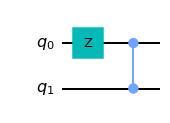

In [78]:
qc = QuantumCircuit(2)
qc.z(0)
qc.cz(0,1)
oracle_ex2 = qc.to_gate()
oracle_ex2.name = "U$_\omega$"
qc.draw('mpl')

In [79]:
matrix = Operator(qc).data 

In [80]:
array_to_latex(matrix)

<IPython.core.display.Latex object>

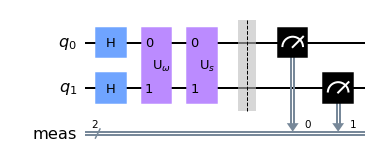

In [81]:
n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.append(oracle_ex2, [0,1])
grover_circuit.append(diffuser(n), [0,1])
grover_circuit.measure_all()
grover_circuit.draw("mpl")

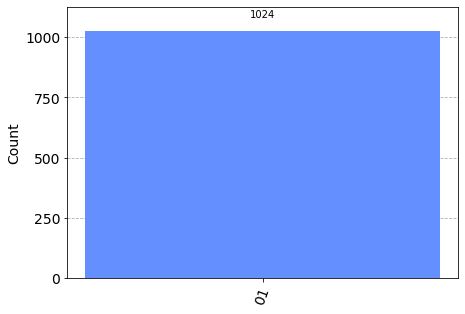

In [82]:
# Local Simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts) 

In [13]:
from qiskit.circuit.library import Diagonal

In [23]:
oraculo = Diagonal([1,-1,1,1])

In [24]:
op = Operator(oraculo)

In [25]:
array_to_latex(op.data)

<IPython.core.display.Latex object>

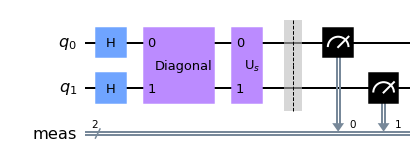

In [83]:
n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.append(oraculo, [0,1])
grover_circuit.append(diffuser(n), [0,1])
grover_circuit.measure_all()
grover_circuit.draw("mpl")

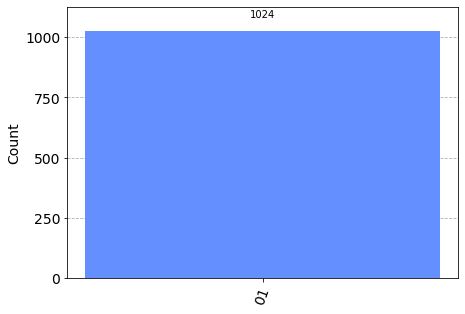

In [84]:
# Local Simulator
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts) 

In [28]:
# CONNECTION WITH IBM ACCOUNT

IBMQ.save_account(my_token)
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
backend = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Least busy backend: ", backend)

Least busy backend:  ibmq_quito


In [29]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue

from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


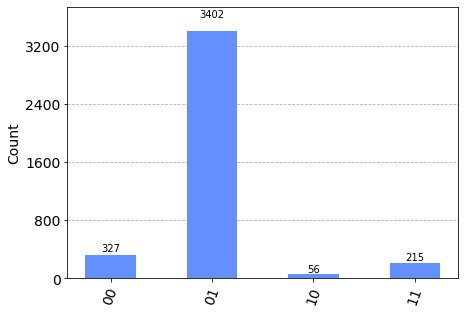

In [30]:
# Get the results from the computation

results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)